In [105]:
import functools
import importlib
import pickle

import keras
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics
import sklearn.model_selection
import sklearn.multiclass
import tqdm

import lapprox.misc.utils as utils
import lapprox.models.ssa as ssa
import lapprox.models.ar as ar
import lapprox.models.arma as arma
import lapprox.models.fft as fft
import lapprox.models.semor as semor
import lapprox.joint.joint_mapping as joint_mapping
import lapprox.segments.normalize as normalize
import lapprox.misc.namespace_cutter as namespace_cutter

importlib.reload(joint_mapping)

%matplotlib inline

In [106]:
with open("data/semor_profiles.pickle", "rb") as f:
    semor_profiles = pickle.load(f)

for key, profile in semor_profiles.items():
    semor_profiles[key] = normalize.shrink_segment(profile, 20)

with open("data/segments.pickle", "rb") as f:
    segments_dict = pickle.load(f) 

## Подготавливаем данные

In [107]:
action_and_segment = []

for key, segments_array in segments_dict.items():
    action_and_segment.extend([(key, s) for s in segments_array if s.size > 30])

segments = [pair[1] for pair in action_and_segment]
actions = [pair[0] for pair in action_and_segment]

In [108]:
normalized_segments = normalize.normalize_segments(segments)
action_and_norm_segment = [(pair[0][0], pair[1])
                           for pair in zip(action_and_segment, normalized_segments)]
le = sklearn.preprocessing.LabelEncoder()
Y = le.fit_transform(actions)
X = np.array(normalized_segments)

In [109]:
models = {
    "ssa_5": ssa.Ssa(5),
    "ssa_10": ssa.Ssa(10),
    "ar_2": ar.Ar(2),
    "ar_4": ar.Ar(4),
#     "arma_2_2": arma.Arma(2, 2),
    "fft_2": fft.Fft(2),
    "fft_5": fft.Fft(5),
    "semor_run": semor.Semor(semor_profiles['run']),
    "semor_walk": semor.Semor(semor_profiles['walk']),
    "semor_up": semor.Semor(semor_profiles['up']),
    "semor_down": semor.Semor(semor_profiles['down'])
}
mapper = joint_mapping.JointMapping(models)
X_intermediate = mapper.fit_transform(X)

In [110]:
def grid_search_using_mapping(X_intermediate, Y, mapper, clf, clf_grid, cv=10, n_jobs=-1):
    cutter = namespace_cutter.CutNamespacesTransformer(namespaces=[], mapping=mapper)

    pipeline = sklearn.pipeline.Pipeline([
        ('namespace_cutter', cutter),
        ('clf', clf)
    ])
    grid = dict({'namespace_cutter__namespaces': utils.all_combinations(list(models))}, **clf_grid)
    gs = sklearn.model_selection.GridSearchCV(pipeline, grid, scoring='neg_log_loss', cv=cv, n_jobs=n_jobs, verbose=1,
                                              return_train_score=True)
    gs.fit(X_intermediate, Y)
    return gs

gss_clojure = functools.partial(grid_search_using_mapping, X_intermediate, Y, mapper)

grids = {}
clfs = {}
grid_search_results = {}

# Logistic regression, l2-regularization.
clfs['lr_l2'] = sklearn.linear_model.LogisticRegressionCV(multi_class='multinomial',
                                                          scoring='neg_log_loss')
grids['lr_l2'] = {}
# Logistic regression, l1-regularization.
clfs['lr_l1'] = sklearn.linear_model.LogisticRegressionCV(solver='liblinear', penalty='l1',
                                                          scoring='neg_log_loss')
grids['lr_l1'] = {}

# Elastic-net
clfs['en'] = sklearn.linear_model.ElasticNetCV()
grids['en'] = {}

In [111]:
# gss_clojure(clfs['en'], grids['en'], n_jobs=1)

In [ ]:
grid_search_results['lr_l2'] = gss_clojure(clfs['lr_l2'], grids['lr_l2'], n_jobs=-1)
grid_search_results['lr_l1'] = gss_clojure(clfs['lr_l1'], grids['lr_l1'], n_jobs=-1)

Fitting 10 folds for each of 1022 candidates, totalling 10220 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 18.6min


In [ ]:
grid_search_results['lr_l1'].best_score_
grid_search_results['lr_l2'].best_score_

# Нейронная сеть

In [10]:
def transform_to_inputs(Y, n_classes):
    Y_binary = np.zeros((Y.shape[0], n_classes))
    for i in range(n_classes):
        Y_binary[:, i] = (Y == i)
    
    return Y_binary

def test_neural_network(X, Y, units, cv=10):
    n_classes = len(set(Y))
    kfold = sklearn.model_selection.StratifiedKFold(n_splits=cv, random_state=1)
    
    scores = []
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = (transform_to_inputs(Y[train_index], n_classes),
                           transform_to_inputs(Y[test_index], n_classes))
        
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(units, activation='relu', input_dim=X_train.shape[1]))
        model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop')
        model.fit(X_train, y_train, epochs=20, verbose=0)
        scores.append(model.evaluate(X_test, y_test, verbose=0))
    
    return np.array(scores)

In [11]:
scores = {}
for i in tqdm.trange(5, 100, 5):
    scores[i] = test_neural_network(X, Y, i)

100%|██████████| 19/19 [07:48<00:00, 24.66s/it]


## Логистическая регрессия на всех признаках

In [65]:
grid = {
    'C': 10 ** np.linspace(-3, 4, 40)
}
clf = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear')
gs = sklearn.model_selection.GridSearchCV(clf, grid, scoring='neg_log_loss', cv=10, n_jobs=-1, verbose=1,
                                          return_train_score=True`)
gs.fit(X_intermediate, Y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    7.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.51178e-03, 2.28546e-03, 3.45511e-03, 5.22335e-03,
       7.89652e-03, 1.19378e-02, 1.80472e-02, 2.72833e-02, 4.12463e-02,
       6.23551e-02, 9.42668e-02, 1.42510e-01, 2.15443e-01, 3.25702e-01,
       4.92388e-01, 7.44380e-01, 1.12534e+00, 1.70125e+00, 2.57191e... 8.37678e+02, 1.26638e+03,
       1.91448e+03, 2.89427e+03, 4.37548e+03, 6.61474e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

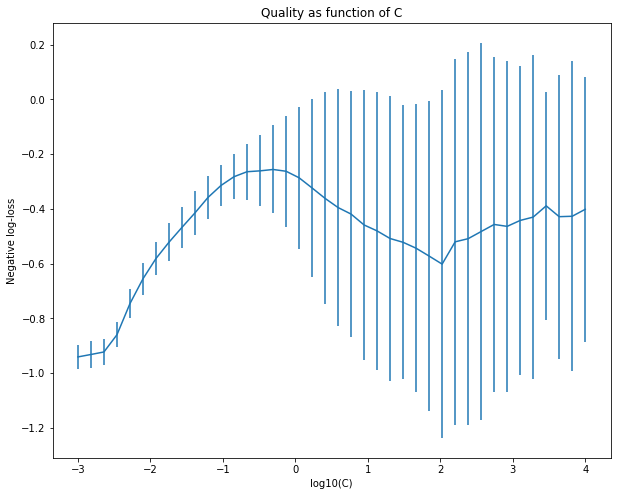

In [91]:
plt.figure(figsize=(10, 8))
c_grid = gs.param_grid['C']
plt.errorbar(np.log10(c_grid), gs.cv_results_['mean_test_score'], gs.cv_results_['std_test_score'])
plt.xlabel('log10(C)')
plt.ylabel('Negative log-loss')
plt.title("Quality as function of C")
plt.savefig("../pics/lr_quality_C.png", dpi=200)

In [87]:
C_to_feature_count = []

for C in grid['C']:
    clf = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=C)
    clf.fit(X_intermediate, Y)
    C_to_feature_count.append((C, np.sum(np.isclose(clf.coef_, 0.0))))

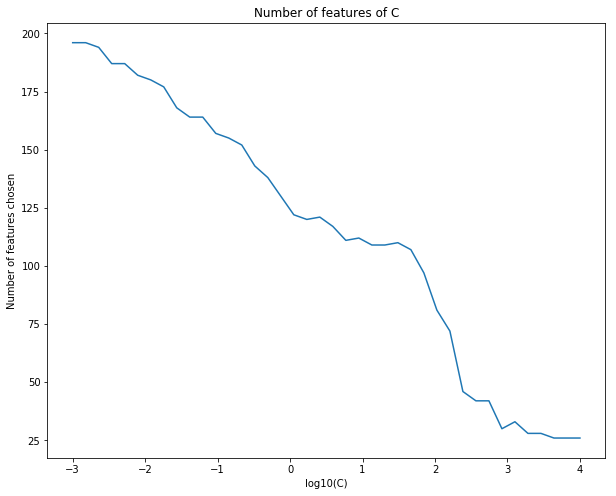

In [92]:
plt.figure(figsize=(10, 8))
plt.plot(np.log10([t[0] for t in C_to_feature_count]), [t[1] for t in C_to_feature_count])
plt.xlabel('log10(C)')
plt.ylabel('Number of features chosen')
plt.title("Number of features of C")
plt.savefig("../pics/lr_n_features_C.png", dpi=200)

# Графики

## Модель с промежуточным пространством

In [34]:
grid_search_results['lr_l2'].best_score_

-0.1895112268157099

## Качество на нейронке

In [22]:
score_tuples = [(k, v) for k, v in scores.items()]
score_tuples = sorted(score_tuples, key = lambda x: x[0])
X = np.array([t[0] for t in score_tuples])
score_arrays = np.array([t[1] for t in score_tuples])

Text(0,0.5,'Negative log-loss')

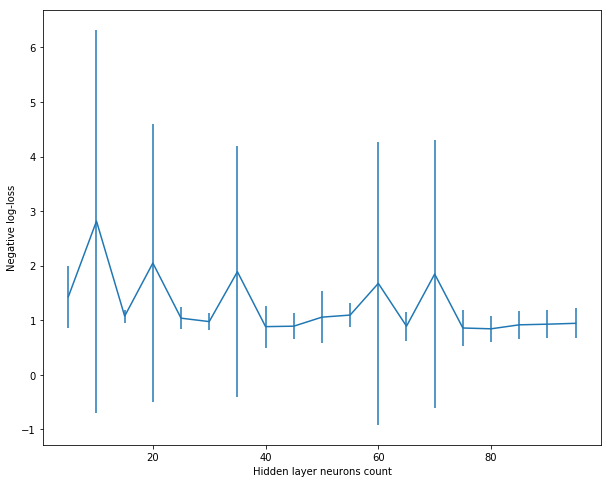

In [30]:
plt.figure(figsize=(10, 8))
plt.errorbar(X, np.mean(score_arrays, axis=1), yerr=np.std(score_arrays, axis=1))
plt.xlabel("Hidden layer neurons count")
plt.ylabel("Negative log-loss")